## Imports

In [80]:
# imports
import numpy as np
import scipy as sp
from time import time, sleep
from fmm import fmm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, LinearOperator, cg
from copy import deepcopy as dc

## FMM

In [61]:
class Fmm(object):
    def __init__(self,pr,proxy_p=1., proxy_r=1., symmetric_fun = 0, lr_type='id'):
        self.pr = pr
        self.proxy_p = proxy_p
        self.proxy_r = proxy_r
        self.tree = pr.tree
        self.n = pr.shape[0]
        tree = self.tree
        size = tree.level[-1]
        self.size = size
        self.basis = [None for i in range(size)]
        self.local_basis = [None for i in range(size)]
        self.T_r = [None for i in range(size)]
        self.T_c = [None for i in range(size)]
        self.index_lvl = [None for i in range(size)]
        self.elim_list = set()
        self.shape = self.pr.shape
        self.lr_type = lr_type
        self.far_mat = {}
        self.mat_tmp = np.zeros((0, pr.shape[0]))
        self.rks_r = [None for i in range(size)]
        self.rks_c = [None for i in range(size)]
    def dot(self, tmp_old):
        tmp = tmp_old.copy()
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        tl = self.tail_lvl
        ans = {}
        ans[0] = self.dot_cl(tmp)
        
        for i in range(level_count-1, tl-1, -1):
            tmp = self.dot_T(i, tmp, 'up')
            ans[level_count-i] = self.dot_il(i, tmp)
        for i in range(tl, level_count):
            ans[level_count-1-i] += self.dot_T(i, ans[level_count-i], 'down')
        return ans[0]
    def dot_cl(self, tmp):
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        close = self.pr.close
        ans = np.zeros(self.n)
        for i in range(level_count-1, tree.higest_leaf_lvl-1, -1):
            # print ('cl_lvl:', i)
            job = [j for j in
                   range(self.tree.level[i], self.tree.level[i+1])]
            for ind in job:
                for i_cl in close[ind]:
                    if not tree.child[ind] and not tree.child[i_cl]:
                        col_ind = self.index_lvl[ind]
                        row_ind = self.index_lvl[i_cl]
                        ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                    elif tree.child[ind] and not tree.child[i_cl]:
                        for ch_ind in tree.child[ind]:
                            col_ind = self.index_lvl[ch_ind]
                            row_ind = self.index_lvl[i_cl]
                            ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                    elif not tree.child[ind] and tree.child[i_cl]:
                         for ch_cl in tree.child[i_cl]:
                            col_ind = self.index_lvl[ind]
                            row_ind = self.index_lvl[ch_cl]
                            ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
        return ans
    def dot_il(self, i, tmp):
        il = self.pr.far
        ans = np.array([]) #np.zeros((1,0))
        job = [j for j in
               range(self.tree.level[i], self.tree.level[i+1])]
        for ind in job:
            ctr = 0
            ans_i = np.zeros(self.rks_r[ind])
            for i_il in job:
                ans_i += self.far_mat[ind, i_il]@tmp[ctr:ctr+self.rks_c[i_il]]
                ctr = ctr + self.rks_c[i_il]
            ans = np.concatenate((ans, ans_i))
        return ans
    def dot_T(self, i, tmp, prod_type):
        job = [j for j in
               range(self.tree.level[i], self.tree.level[i+1])]
        if prod_type == 'up':
            ans = np.array([])
            for ind in job:
                ans = np.concatenate((ans, self.T_c[ind].dot(tmp[self.index_lvl[ind]])))
        else:
            ctr = 0
            ans = np.zeros(self.n)
            for ind in job:   
                ans[self.index_lvl[ind]] = self.T_r[ind].dot(tmp[ctr:ctr+self.rks_r[ind]])
                ctr = ctr+self.rks_r[ind]
        return ans
def buildmatrix(ind, fmm):
    pr = fmm.pr
    tree = fmm.tree
    i = 2
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    mat = np.zeros((fmm.index_lvl[ind].size,0))
    for i_col in job:
        if i_col in pr.far[ind]:
            mat_tmp = pr._func(tree.data, fmm.index_lvl[ind], tree.data, fmm.index_lvl[i_col])
            mat = np.hstack((mat,mat_tmp))
        else:
            mat_tmp = np.zeros((fmm.index_lvl[ind].shape[0], fmm.index_lvl[i_col].shape[0]))
            mat = np.hstack((mat,mat_tmp))
    return mat
def build_fmm(pr, lr_type='id'):
    tree = pr.tree
    level_count = len(tree.level) - 2
    tau = pr.eps
    fmm = Fmm(pr, symmetric_fun = 1, lr_type=lr_type)
    ind_l = []
    fmm.tail_lvl = pr.tail_lvl

    i=2
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    for ind in job:
        fmm.index_lvl[ind] = fmm.tree.index[ind]
    for ind in job:
        matrix = buildmatrix(ind, fmm)
        u, s, _ = np.linalg.svd(matrix, full_matrices=False)
        k = np.argmin(abs(s - tau))
        fmm.rks_r[ind] = k
        fmm.rks_c[ind] = k
        fmm.T_r[ind] = u[:,:k]
        fmm.T_c[ind] = u[:,:k].T
        
    for ind in job:   
        
        ptr_r = 0
        for ind_f in  pr.far[ind]:
            bl = pr._func(tree.data, fmm.index_lvl[ind], tree.data, fmm.index_lvl[ind_f])
            fmm.far_mat[ind, ind_f] = (fmm.T_r[ind].T @ bl@ fmm.T_c[ind_f].T)[:fmm.rks_r[ind], :fmm.rks_c[ind_f]]
        for ind_f in  pr.close[ind]:
            fmm.far_mat[ind, ind_f] = np.zeros((fmm.rks_r[ind], fmm.rks_c[ind_f]))
    return fmm
def exp_fun(data1, list1, data2, list2):
    sigma = 0.1
    n = list1.size
    m = list2.size
    vertex1 = data1.vertex
    vertex2 = data2.vertex
    N = data1.vertex.shape[1]
    ans = np.ndarray((n, m), dtype=np.float64)
    for i in range(n):
        for j in range(m):
            d2 = 0
            for i_dim in range(data1.ndim):
                d2 += (vertex1[i_dim,list1[i]]-vertex2[i_dim,list2[j]])**2
            d2 = np.sqrt(d2)
            if (vertex1[:,list1[i]] == vertex2[:,list2[j]]).all():
                ans[i, j] = np.exp(-d2/sigma) 
            else:
                ans[i, j] = np.exp(-d2/sigma)
    return ans
def dot_ut(self, vec):
    i = 2
    job = [j for j in
               range(self.tree.level[i], self.tree.level[i+1])]
    ans = np.array([])
    for ind in job:
        ans = np.concatenate((ans, self.T_r[ind].T.dot(vec[self.index_lvl[ind]])))
    return ans
def dot_vt(self, vec):
    ctr = 0
    ans = np.zeros(self.n)
    i = 2
    job = [j for j in
               range(self.tree.level[i], self.tree.level[i+1])]
    for ind in job:   
        ans[self.index_lvl[ind]] = self.T_c[ind].T.dot(vec[ctr:ctr+self.rks_r[ind]])
        ctr = ctr+self.rks_r[ind]
    return ans
def make_a_tilda(self):
    i = 2
    job = [j for j in range(self.tree.level[i], self.tree.level[i+1])]
    n = 0
    m = 0
    pr = self.pr
    index = pr.tree.index
    for i in job:
        n += self.rks_r[i]
    for i in job:
        m += self.rks_c[i]
#     print(m,n)        
    a_tild = np.zeros((n,m))
    ptr_r = 0 
    for i in job:
        ptr_c = 0
        for j in job:
            if j in pr.close[i]:
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                big_cl = self.pr.func(index[i], index[j])
                a_tild[np.ix_(row_ind, col_ind)] = self.T_r[i].T @ big_cl @ self.T_c[j].T
            elif j in pr.far[i]:
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                a_tild[np.ix_(row_ind, col_ind)] = self.far_mat[i, j]
            else:
                print('Bug!')
            ptr_c = ptr_c + self.rks_c[j]
        ptr_r = ptr_r + self.rks_r[i]
    return a_tild           

In [30]:
#set_up_problem
np.random.seed(0)

func = exp_fun
close_r = 1. 
num_child_tree = 'hyper' 
eps = 5.1e-6
ndim = 2
n = 32
bs = 64

t0 = time()
pr = fmm.build_problem(geom_type='cube',
                      n=n,
                      ndim=ndim,
                      block_size=bs,
                      func=func,
                      point_based_tree=0,
                      close_r=close_r,
                      num_child_tree=num_child_tree,
                      random_points=0,
                      eps=eps)
print(f'problem-build time: {time() - t0}\nN = {pr.shape}')

problem-build time: 0.01851201057434082
N = (1024, 1024)


In [31]:
#build H2 matrix
fmm_mat = build_fmm(pr, lr_type='svd')

In [32]:
# Accurasy test
test_v = np.random.rand(fmm_mat.n)
mat = fmm_mat.pr.func(np.arange(pr.shape[0]),np.arange(pr.shape[0]))
test_ans = mat.dot(test_v)
my_ans = fmm_mat.dot(test_v)
err = test_ans - my_ans
print(f'Approximation accurasy: {np.linalg.norm(err)/np.linalg.norm(test_ans)}')

Approximation accurasy: 5.238023848640841e-08


## CG

### code 

In [48]:
# my cg
def cg_my(A, b, x0=None, n_iter=100, verbose=0, tol = 1e-10, x_true = None, plot_res=0, p=None, r1=None, x_chgd = 0):
    
    n = A.shape[0]
    m = A.shape[1]
    max_it = -1
    if n != m:
        raise NameError('Matrix should be square')
    if x0 is None:
        x0 = np.zeros(n, dtype=np.double)
    res = np.zeros(n_iter + 1)
    anorm = np.zeros(n_iter + 1)
    if verbose:
        print ('Solving with Conjugate Gradien method')
    if r1 is None:
        r = b - A.dot(x0)
        p = r.copy()
    elif x_chgd:
        r = b - A.dot(x0)
        beta = np.dot(r, r) / np.dot(r1, r1)
        p = beta * p + r
    else:
        r = r1.copy()
    r_k_norm = np.dot(r, r)
    res[0] = np.linalg.norm(b - A.dot(x0))/np.linalg.norm(b)
    ek = x_true - x0
    anorm[0] = np.sqrt(ek.dot(A.dot(ek)))
    for i in range(n_iter):
        Ap = A.dot(p)
        alpha = r_k_norm / np.dot(p, Ap)
        x0 += alpha * p
        r -= alpha * Ap
        r1 = r.copy()
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        ek = x_true - x0
        res[i+1] = np.linalg.norm(b - A.dot(x0))/np.linalg.norm(b)
        anorm[i+1] = np.sqrt(ek.dot(A.dot(ek)))
        p = beta * p + r
        if verbose:
            print(f"iter:{i}, xk: {np.linalg.norm(x0)}, a-norm: {anorm[i]:.8f}, residual: {res[i+1]}, res2{np.linalg.norm(r)/np.linalg.norm(b)}", end='\n')
        if res[i] < tol:
            max_it = i 
            break         
    if max_it == -1:
        max_it = n_iter
    if plot_res:
        return (x0, p, r1), (res[:max_it+2], anorm[:max_it+2])
    else:
        return x0, 0

In [33]:
# scipy cg
class Results(object):
    def __init__(self, A, b, x_tr, x_ap, disp=0):
        self.A = A
        self.b = b
        self.x_tr = x_tr
        self.x_ap = x_ap
        self.disp = disp
        self.res = []
        self.anorm_tr = []
        self.anorm_ap = []
        self.niter = 0
    def __call__(self,  xk):
        rk = np.linalg.norm(self.b - self.A.dot(xk))/np.linalg.norm(self.b)
        ek_tr = self.x_tr - xk
        ek_ap = self.x_ap - xk
        an_tr = np.sqrt(ek_tr.dot(self.A.dot(ek_tr)))
        an_ap = np.sqrt(ek_ap.dot(self.A.dot(ek_ap))) 
        
        self.res.append(rk)
        self.anorm_tr.append(an_tr)
        self.anorm_ap.append(an_ap)
        if self.disp:
            print(f"iter:{self.niter}, res:{rk}, an_tr:{an_tr}, an_ap:{an_ap}")
        self.niter += 1

In [34]:
# make b
np.random.seed(0)
b = np.random.rand(fmm_mat.n)

In [35]:
# make full n by n matrix from approximated H2 matrix
pr = fmm_mat.pr
tree = pr.tree
level_count = len(tree.level) - 2
close = fmm_mat.pr.close
i=2
A_full_compr = np.zeros_like(mat)
job = [j for j in
       range(fmm_mat.tree.level[i], fmm_mat.tree.level[i+1])]
for row in job:
    index_row = fmm_mat.index_lvl[row]
    for col in job:
        index_col = fmm_mat.index_lvl[col]
        if col in close[row]:
            cl_bl = fmm_mat.pr.func(index_row, index_col)
            print(f'close, row: {row}, col: {col}', end='\r')
            A_full_compr[np.ix_(index_row, index_col)] = cl_bl
        else:
            print(f'far  , row: {row}, col: {col}', end='\r')
            fr_bl = fmm_mat.T_r[row]@fmm_mat.far_mat[row,col]@fmm_mat.T_c[col]
            A_full_compr[np.ix_(index_row, index_col)] = fr_bl
print(f"\n||A_full_compr-mat||/||A_full_compr||={np.linalg.norm(A_full_compr-mat)/ np.linalg.norm(A_full_compr)}")


close, row: 20, col: 20
||A_full_compr-mat||/||A_full_compr||=3.457190049426565e-07


In [36]:
# make true x
x_true_compr = np.linalg.solve(A_full_compr, b)
x_true_full = np.linalg.solve(mat, b)
print(f"\n||x_compr-x||/||x_compr||={np.linalg.norm(x_true_compr-x_true_full)/ np.linalg.norm(x_true_compr)}")


||x_compr-x||/||x_compr||=2.5241769552867163e-06


In [59]:
# compare my_cg with scipy cg

n_iter=200
tol=1e-10

# run scipy cg
callback = Results(mat, b, x_true_full, x_true_compr, disp = 0)
tmp = cg(mat, b, callback=callback, tol=tol, maxiter=n_iter)

# run my cg
tmp, (res, anorm) = cg_my(mat, b, x0=None,  x_true = x_true_full, n_iter=n_iter, tol=tol, plot_res=1)

print(np.linalg.norm(res[1:-1] - callback.res))

0.0


## FMM-MG

In [74]:
def fmm_mg(A, b, xk=None, fmm_mat = None, mg_type = 'no_mg', x_true = None, n_iter = 10, tol = 1e-10, n_v_iter = 0): 
    if xk is None:
        xk = np.zeros_like(b)
    res = np.array([])
    anorm = np.array([])
    p = None
    r1 = None
    for i in range(n_v_iter):
#         print(f"v iteration: {i+1}, {mg_type}")
        (xk, p, r1), res_up = cg_my(A, b, x0=xk,x_true = x_true, verbose=0, n_iter=n_iter, tol=tol, 
                                plot_res = 1, p=p, r1=r1, x_chgd = 0)
        res = np.concatenate((res, res_up[0]))
        anorm  = np.concatenate((anorm, res_up[1]))
        if mg_type == 'no_mg':
            res_tmp = np.array([np.linalg.norm(b - A.dot(xk))/np.linalg.norm(b)])
            res = np.concatenate((res, res_tmp ))
            ek = xk - x_true
            anorm  = np.concatenate((anorm, np.array([np.sqrt(np.dot(ek, A.dot(ek)))])))
            (xk, p, r1), res_down = cg_my(A, b, x0=xk, x_true = x_true, verbose=0, n_iter=n_iter, tol=tol, 
                                        plot_res = 1, p=p, r1=r1, x_chgd = 0)
            res = np.concatenate((res, res_down[0]))
            anorm  = np.concatenate((anorm, res_down[1]))
        elif mg_type == 'u':
            xk_old = xk.copy()
            r = b - A.dot(xk)
            r_tild = dot_ut(fmm_mat, r)
            e_tild = np.linalg.solve(a_tild, r_tild)
            
            plt.show()
            e = dot_vt(fmm_mat, e_tild)
            ek = xk - x_true
    
            xk = xk_old + e
            ek = xk - x_true
            plt.show()
            res = np.concatenate((res, np.array([np.linalg.norm(b - A.dot(xk))/np.linalg.norm(b)])))
            anorm  = np.concatenate((anorm, np.array([np.sqrt(np.dot(ek, A.dot(ek)))])))
            
            (xk, p, r1), res_down = cg_my(A, b, x0=xk, x_true=x_true, verbose=0, n_iter=n_iter, tol=tol, 
                                        plot_res = 1, p=p, r1=r1, x_chgd = 1)
            ek = xk - x_true
            res = np.concatenate((res, res_down[0]))
            anorm  = np.concatenate((anorm, res_down[1]))
        else:
            print('Wrong mg_type')
            return 0, 0, 0
        if res[-1] < tol:
            break
    return xk, res, anorm

In [75]:
# data = {}
# a_tild = make_a_tilda(fmm_mat)

In [78]:
n_v_iter = 20
n_iter = 1

tol = 1e-10
method = "cg"

# A = mat
# x_true = x_true_full

A = A_full_compr
x_true = x_true_compr




data[n_iter, method, eps, 'no_mg'] = fmm_mg(A, b, mg_type = 'no_mg', x_true =  x_true,   fmm_mat=fmm_mat, n_iter = n_iter, 
                               tol = tol, n_v_iter = n_v_iter)
data[n_iter, method, eps, 'u'] = fmm_mg(A, b, mg_type = 'u',  fmm_mat = fmm_mat, x_true =  x_true, n_iter = n_iter, 
                               tol = tol, n_v_iter = n_v_iter)

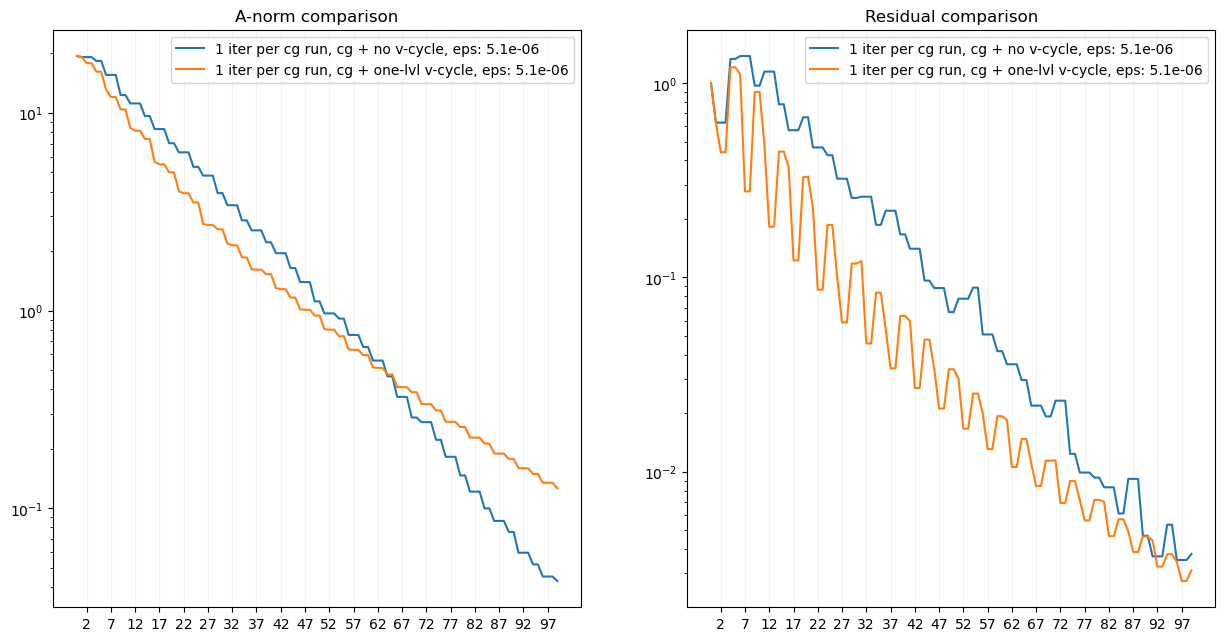

In [79]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15, 7.5))
# marker='.'
marker = None
for niter_i in [n_iter]:
    for eps_i in [5.1e-6]:
        for mg_type_i in ['no_mg', 'u']:
            if mg_type_i == 'no_mg':
                label_text = 'no v-cycle'
            elif mg_type_i == 'u':
                label_text = 'one-lvl v-cycle'
            else:
                label_text = mg_type_i
            axs[0].plot(data[niter_i, method, eps_i, mg_type_i][2], label=f'{niter_i} iter per cg run, {method} + {label_text}, eps: {eps_i}',  marker=marker)
axs[0].set_yscale('log')
axs[0].set_title(f'A-norm comparison')
axs[0].set_xticks(np.arange(n_iter+1, data[n_iter, method, eps_i, mg_type_i][2].shape[0] + n_iter+1, step=(n_iter+1)*2+1))
axs[0].grid(axis='x', color='0.95')
axs[0].legend()

for niter_i in [n_iter]:
    for eps_i in [5.1e-6]:
        for mg_type_i in ['no_mg', 'u']:
            if mg_type_i == 'no_mg':
                label_text = 'no v-cycle'
            elif mg_type_i == 'u':
                label_text = 'one-lvl v-cycle'
            else:
                label_text = mg_type_i
            axs[1].plot(data[niter_i, method, eps_i, mg_type_i][1], label=f'{niter_i} iter per cg run, {method} + {label_text}, eps: {eps_i}',  marker=marker)

axs[1].set_title(f'Residual comparison')
axs[1].set_yscale('log')
axs[1].set_xticks(np.arange(n_iter+1, data[n_iter, method, eps_i, mg_type_i][2].shape[0] + n_iter+1, step=(n_iter+1)*2+1))
axs[1].grid(axis='x', color='0.95')
axs[1].legend()